## Supervised machine learning
### Guillermo Altesor
* Phase 1: Data loading and descriptive analysis.
* Phase 2: Joint training and test sampling.
* Phase 3: Adjustment of the Naive Bayes algorithm.
* Phase 4: Adjustment of the Support Vector Machine algorithm.
* Phase 5: Validation of the chosen algorithm based on the ROC curve, the area under the curve, the confusion matrix and the precision. Assess if there is overfitting.

## PHASE 1: Data loading and descriptive analysis

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as xp

# DATA FILE LOADING
file = 'ASI_casoPractico.csv'
data = pd.read_csv(file, sep = ';')

data.agg(['nunique']).T

,nunique
ID,2126
b,979
e,1064
LBE,48
AC,22
FM,96
UC,19
ASTV,75
MSTV,57
ALTV,87


In [ ]:
# Proportion of normal and abnormal fetal states
a, b = data["Target"].value_counts()
print("Número de estados normales: " + str(a))
print("Número de estados anormales: " + str(b))

Número de estados normales: 1655
Número de estados anormales: 471


In [ ]:
# Measures of centralization, location and dispersion for the variables:
# FM, ALTV y Median.
data[["FM", "ALTV","Median"]].describe().T

,count,mean,std,min,25%,50%,75%,max
FM,2126.0,7.241298,37.125309,0.0,0.0,0.0,2.0,564.0
ALTV,2126.0,9.846660,18.396880,0.0,0.0,0.0,11.0,91.0
Median,2126.0,138.090310,14.466589,77.0,129.0,139.0,148.0,186.0


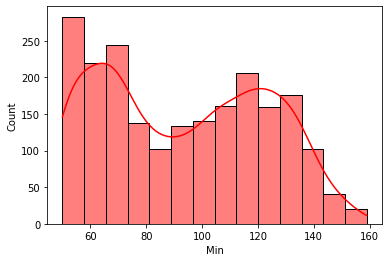

In [ ]:
# Histogram for the variables: LBE, DS and Min.
# sns.histplot(data = data,x = 'LBE',color = 'red',kde = True)
# sns.histplot(data = data,x = 'DS',color = 'red',kde = True)
sns.histplot(data = data,x = 'Min',color = 'red',kde = True)

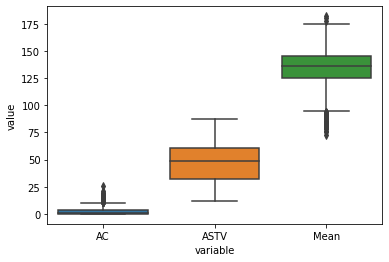

In [ ]:
# Graphic box-plot for the variables: AC, ASTV and Mean.
sns.boxplot(x="variable", y="value", data=pd.melt(data[["AC", "ASTV", "Mean"]]))

In [ ]:
# remove unnecessary columns
data = data.drop(["ID","b","e","DR"], axis = 1)
data.head()

,LBE,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,Target
0,120,0,0,0,73,0.5,43,2.4,0,0,...,62,126,2,0,120,137,121,73,1,1
1,132,4,0,4,17,2.1,0,10.4,2,0,...,68,198,6,1,141,136,140,12,0,0
2,133,2,0,5,16,2.1,0,13.4,2,0,...,68,198,5,1,141,135,138,13,0,0
3,134,2,0,6,16,2.4,0,23.0,2,0,...,53,170,11,0,137,134,137,13,1,0
4,132,4,0,5,16,2.4,0,19.9,0,0,...,53,170,9,0,137,136,138,11,1,0


The three variables that have the highest correlation with the target are ASTV (0.49), ALTV (0.49) and AC (-0.37). The three make a lot of sense that they present a correlation with the target, since they indicate very valuable information about heart abnormalities.

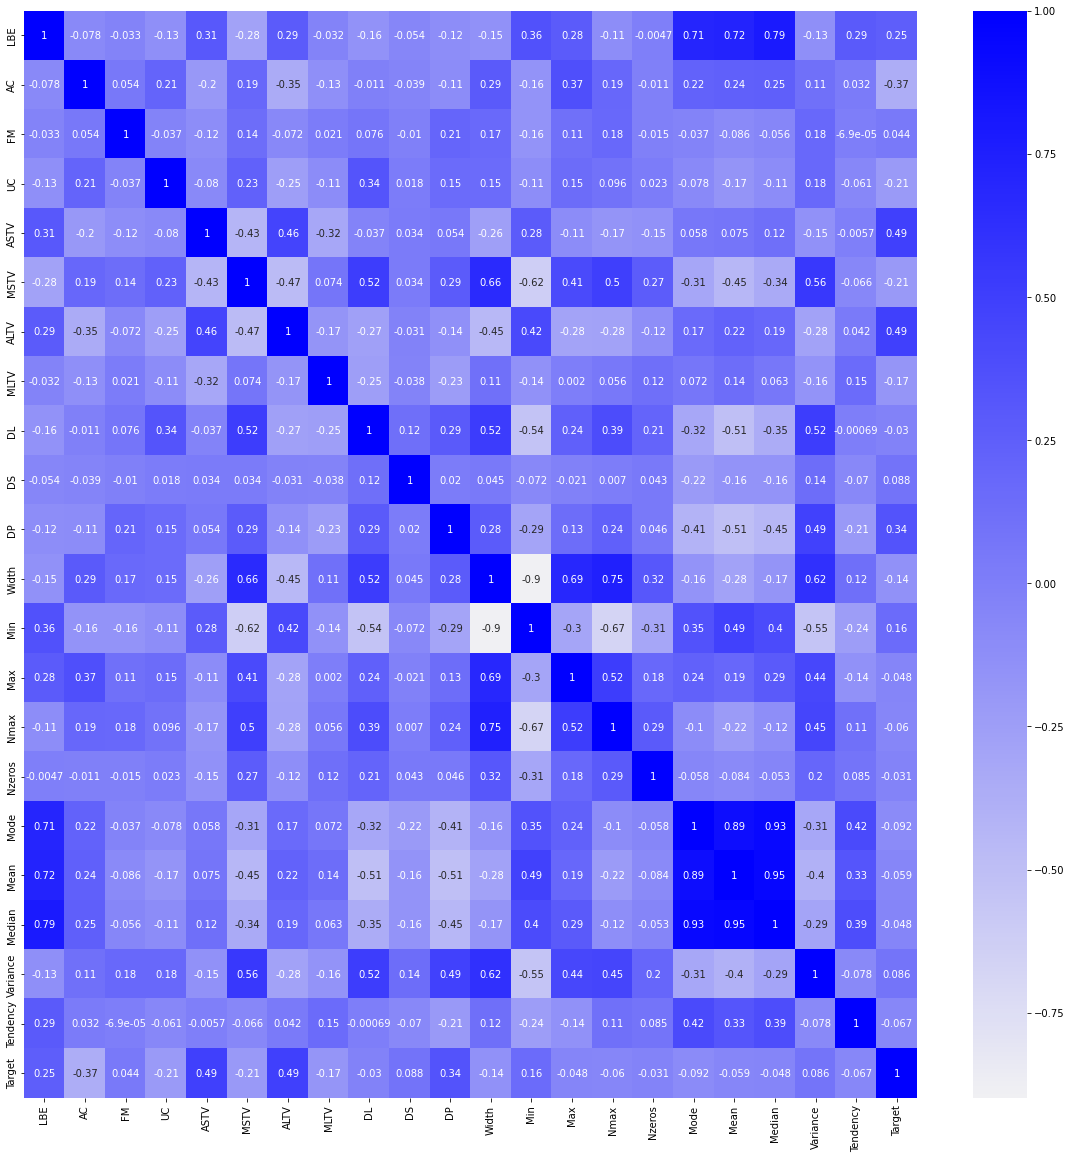

In [ ]:
# MATRIZ DE CORRELACIONES
plt.figure(figsize=(20,20))
corr = data.corr()
cmap = sns.color_palette("light:b", as_cmap=True)
sns.heatmap(corr, annot=True, cmap=cmap)


## Phase 2: Sampling. Training and test set.


In [ ]:
# TRAINING AND TEST
from sklearn.model_selection import train_test_split
X = data.loc[:, data.columns != "Target"]
y = data.loc[:, data.columns == "Target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 0)


## Phase 3: Adjustment of the Naive Bayes algorithm.


Since most of our variables are continuous quantitative, we will use Gaussian

In [ ]:
# MODELING
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

modelNB = gnb.fit(X_train, y_train.values.ravel())
y_pred_train = modelNB.predict_proba(X_train) 
y_pred_test = modelNB.predict_proba(X_test)


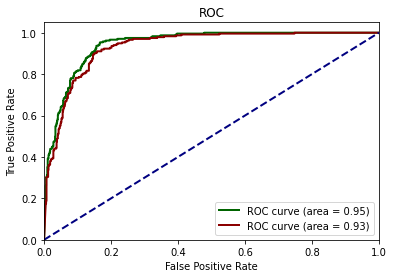

In [ ]:
# # VALIDATION
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

# ROC CURVE & AUC FOR TRAINING
fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_train[:, 1])
roc_auc_train = auc(fpr_train, tpr_train)

# ROC CURVE & AUC FOR TEST
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_test[:, 1])
roc_auc_test = auc(fpr_test, tpr_test)

# CHART
plt.figure()
lw = 2

plt.plot(fpr_train,tpr_train,color="darkgreen",lw=lw,label="ROC curve (area = %0.2f)" % roc_auc_train,)
plt.plot(fpr_test,tpr_test,color="darkred",lw=lw,label="ROC curve (area = %0.2f)" % roc_auc_test,)

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC")
plt.legend(loc="lower right")
plt.show()


We have variables with a high predictive power, given that the area under the train curve is 0.95 and test curve is 0.93. There is overfitting, but very little.

## Phase 4: Adjustment of the Support Vector Machine algorithm.
 
We use GridSearchCV for a description of values ​​to help us fit the model.

In [ ]:
# Preprocessing, modeling and validation
from sklearn import svm, datasets
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

#Warnings configuration
import warnings
warnings.filterwarnings('ignore')

# Hyperparameters
param_grid = [
    {"kernel": ["rbf"], "gamma": [1e-3, 1e-4], "C": [0.1,1,10]},
    {"kernel": ["linear"], "C": [0.1,1,10]},
    {"kernel": ["poly"], "C": [0.1,1,10], "degree": [2,5]},
]
 
grid = GridSearchCV(
        estimator  = SVC(),
        param_grid = param_grid, 
        scoring    = 'roc_auc', # roc_auc, accuracy
        n_jobs     = -1,
        cv         = 3, 
        verbose    = 0,
        return_train_score = True
      )

grid.fit(X = X_train, y = y_train)

GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [0.1, 1, 10], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [0.1, 1, 10], 'kernel': ['linear']},
                         {'C': [0.1, 1, 10], 'degree': [2, 5],
                          'kernel': ['poly']}],
             return_train_score=True, scoring='roc_auc')

In [ ]:
# Grid results
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False) \
    .head(10)

,param_C,param_gamma,param_kernel,param_degree,mean_test_score,std_test_score,mean_train_score,std_train_score
6,0.1,NaN,linear,NaN,0.963630,0.010899,0.970071,0.006553
7,1,NaN,linear,NaN,0.963217,0.011037,0.972587,0.005491
8,10,NaN,linear,NaN,0.963156,0.011326,0.973054,0.004852
5,10,0.0001,rbf,NaN,0.960784,0.005379,0.981283,0.001894
14,10,NaN,poly,5,0.954903,0.008854,0.971216,0.002093
2,1,0.001,rbf,NaN,0.948559,0.002482,0.988743,0.003375
3,1,0.0001,rbf,NaN,0.948488,0.003802,0.962389,0.001818
4,10,0.001,rbf,NaN,0.947906,0.007447,0.997538,0.001651
13,10,NaN,poly,2,0.938226,0.007961,0.948988,0.002895
12,1,NaN,poly,5,0.935822,0.008932,0.948708,0.003521


In [ ]:
print(grid.best_params_)
print(grid.best_estimator_)

{'C': 0.1, 'kernel': 'linear'}
SVC(C=0.1, kernel='linear')


 
The best fit for the SVC model is a C=0.1 and a linear kernel. We readjust the model accordingly.

In [ ]:
# SVM Lineal
svmLineal = svm.SVC(C = 0.1
                    ,kernel='linear'
                    ,degree = 1
                    ,probability = True) 

Model fit
svmLineal.fit(X_train, y_train)

# VALIDATION WITH THE TEST SET
y_proba_train_svm = svmLineal.predict_proba(X_train)
y_proba_test_svm = svmLineal.predict_proba(X_test)

In [ ]:
# Training
fpr_train_svm, tpr_train_svm, _ = roc_curve(y_train, y_proba_train_svm[:, 1])
roc_auc_train_svm = auc(fpr_train_svm, tpr_train_svm)
# 
# Test
fpr_test_svm, tpr_test_svm, _ = roc_curve(y_test, y_proba_test_svm[:, 1])
roc_auc_test_svm = auc(fpr_test_svm, tpr_test_svm)

## Phase 5: Validation of the chosen algorithm based on the ROC curve, the area under the curve, the confusion matrix and the precision. Assess if there is overfitting.

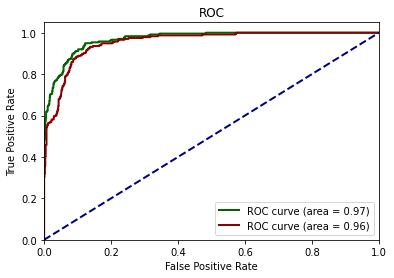

In [ ]:
plt.figure()
lw = 2

plt.plot(fpr_train_svm,tpr_train_svm,color="darkgreen",lw=lw,label="ROC curve (area = %0.2f)" % roc_auc_train_svm,)
plt.plot(fpr_test_svm,tpr_test_svm,color="darkred",lw=lw,label="ROC curve (area = %0.2f)" % roc_auc_test_svm,)

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC")
plt.legend(loc="lower right")
plt.show()

We have a very good model with SVM with hardly any overfitting.

In [ ]:
#confusion matrix
from sklearn.metrics import confusion_matrix 
y_pred = svmLineal.predict(X_test) 
confusion_matrix(y_pred, y_test) 
from sklearn.metrics import accuracy_score, classification_report 
accuracy_score(y_pred, y_test) 
print(classification_report(y_pred, y_test))


              precision    recall  f1-score   support

           0       0.95      0.92      0.93       857
           1       0.70      0.80      0.75       206

    accuracy                           0.89      1063
   macro avg       0.83      0.86      0.84      1063
weighted avg       0.90      0.89      0.90      1063

